# Les imports 

In [1]:
# --- Notebook : Modèle Linéaire - Cas de Tests de Régression ---
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# === Chargement de la bibliothèque Rust compilée ===
lib = ctypes.CDLL("../../../target/release/mymodel.dll")

In [3]:
# === Régression par descente de gradient ===
lib.create_linear_model_gradient_descent.argtypes = [ctypes.c_size_t, ctypes.c_double, ctypes.c_size_t]
lib.create_linear_model_gradient_descent.restype = ctypes.c_void_p

lib.train_linear_model_gradient_descent.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_size_t
]

lib.predict_linear_model_gradient_descent.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_double), ctypes.c_size_t]
lib.predict_linear_model_gradient_descent.restype = ctypes.c_double


## Régression

### Linear Simple 2D :
        Linear Model : OK
        

x = 1.0 → y attendu = 2.0, y prédit = 2.000
x = 2.0 → y attendu = 3.0, y prédit = 3.000

MAE (erreur absolue moyenne) : 0.0000
RMSE (erreur quadratique moyenne) : 0.0000
Précision relative : 100.00%


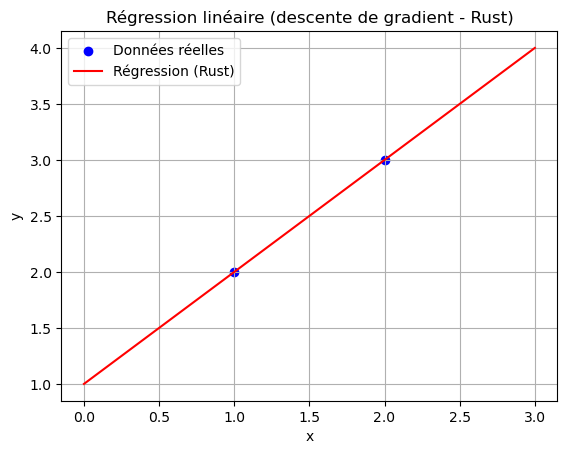

In [4]:
# === Données ===
X = np.array([[1], [2]], dtype=np.float64)
Y = np.array([2, 3], dtype=np.float64)
n_samples, n_features = X.shape

# === Créer le modèle Rust ===
learning_rate = 0.1
epochs = 5000
model_ptr = lib.create_linear_model_gradient_descent(n_features, learning_rate, epochs)

# === Entraîner le modèle ===
X_flat = X.flatten().astype(np.float64)
Y_float = Y.astype(np.float64)

lib.train_linear_model_gradient_descent(
    model_ptr,
    X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y_float.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    n_samples,
    n_features
)

# === Prédiction sur X
Y_pred = np.array([
    lib.predict_linear_model_gradient_descent(
        model_ptr,
        x.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n_features
    )
    for x in X
])

# === Affichage résultats
for x, y_true, y_hat in zip(X, Y, Y_pred):
    print(f"x = {x[0]:.1f} → y attendu = {y_true:.1f}, y prédit = {y_hat:.3f}")

mae = np.mean(np.abs(Y - Y_pred))
rmse = np.sqrt(np.mean((Y - Y_pred)**2))
value_range = Y.max() - Y.min()
accuracy_pct = 100 * (1 - rmse / value_range) if value_range > 0 else 100.0

print(f"\nMAE (erreur absolue moyenne) : {mae:.4f}")
print(f"RMSE (erreur quadratique moyenne) : {rmse:.4f}")
print(f"Précision relative : {accuracy_pct:.2f}%")

# === Affichage graphique
x_test = np.linspace(0, 3, 100).reshape(-1, 1)
y_test_pred = np.array([
    lib.predict_linear_model_gradient_descent(
        model_ptr,
        x.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n_features
    )
    for x in x_test
])

plt.scatter(X, Y, label="Données réelles", color="blue")
plt.plot(x_test, y_test_pred, color="red", label="Régression (Rust)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Régression linéaire (descente de gradient - Rust)")
plt.legend()
plt.grid(True)
plt.show()


### Non Linear Simple 2D :
        Linear Model    : OK

x = 1.0 → y attendu = 2.0, y prédit = 2.257
x = 2.0 → y attendu = 3.0, y prédit = 2.494
x = 3.0 → y attendu = 2.5, y prédit = 2.731

MAE (erreur absolue moyenne) : 0.3313
RMSE (erreur quadratique moyenne) : 0.3538
Précision relative : 64.62%


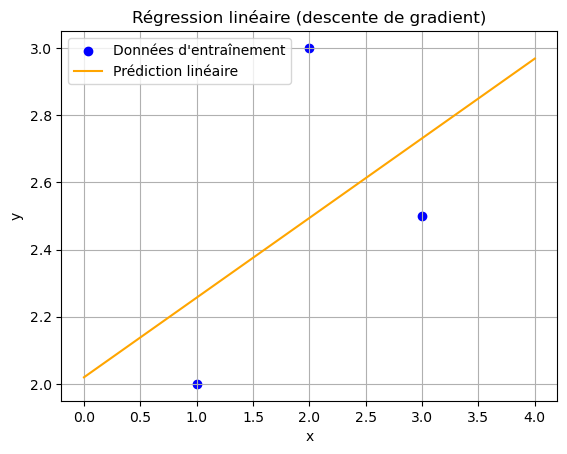

In [5]:
X = np.array([[1], [2], [3]], dtype=np.float64)
Y = np.array([2, 3, 2.5], dtype=np.float64)
n_samples, n_features = X.shape

# Conversion des données pour Rust
X_flat = X.flatten().astype(np.float64)
Y_float = Y.astype(np.float64)

# Création du modèle
model_ptr = lib.create_linear_model_gradient_descent(n_features, 0.01, 5000)



x_ptr = X_flat.flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double))
y_ptr = Y_float.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

# Entraînement
lib.train_linear_model_gradient_descent(model_ptr, x_ptr, y_ptr, n_samples, n_features)

# Prédictions
Y_pred = np.array([
    lib.predict_linear_model_gradient_descent(
        model_ptr,
        x.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n_features
    )
    for x in X
])

# === Affichage résultats
for x, y_true, y_hat in zip(X, Y, Y_pred):
    print(f"x = {x[0]:.1f} → y attendu = {y_true:.1f}, y prédit = {y_hat:.3f}")

mae = np.mean(np.abs(Y - Y_pred))
rmse = np.sqrt(np.mean((Y - Y_pred)**2))
value_range = Y.max() - Y.min()
accuracy_pct = 100 * (1 - rmse / value_range) if value_range > 0 else 100.0

print(f"\nMAE (erreur absolue moyenne) : {mae:.4f}")
print(f"RMSE (erreur quadratique moyenne) : {rmse:.4f}")
print(f"Précision relative : {accuracy_pct:.2f}%")

# === Affichage graphique
x_test = np.linspace(0, 4, 200).reshape(-1, 1)
y_test_pred = np.array([
    lib.predict_linear_model_gradient_descent(
        model_ptr,
        x.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n_features
    )
    for x in x_test
])

plt.title("Régression linéaire (descente de gradient)")
plt.scatter(X, Y, label="Données d'entraînement", color="blue")
plt.plot(x_test, y_test_pred, label="Prédiction linéaire", color="orange")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()



### Linear Simple 3D :
        Linear Model    : OK

# Exemple prof

Exemple 0 : Prédit = 2.000, Vrai = 2.0
Exemple 1 : Prédit = 3.000, Vrai = 3.0
Exemple 2 : Prédit = 2.500, Vrai = 2.5

MAE (erreur absolue moyenne) : 0.3313
RMSE (erreur quadratique moyenne) : 0.3538
Précision relative : 64.62%


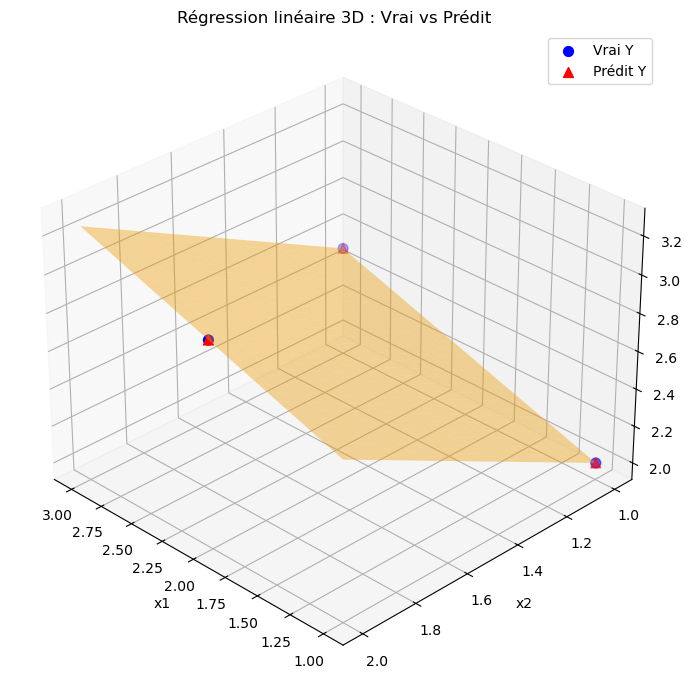

In [18]:
X = np.array([
    [1, 1],
    [2, 2],
    [3, 1]
])

Y = np.array([2, 3, 2.5])

n_samples, n_features = X.shape
# === Création et entraînement du modèle ===
model_ptr = lib.create_linear_model_gradient_descent(n_features, 0.1, 1000)

X_flat = X.flatten().astype(np.float64)
Y_float = Y.astype(np.float64)

x_ptr = X_flat.flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double))
y_ptr = Y_float.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

lib.train_linear_model_gradient_descent(model_ptr, x_ptr, y_ptr, n_samples, n_features)



predictions = []
for i in range(n_samples):
    x = X[i].astype(np.float64)
    x_ptr = x.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    pred = lib.predict_linear_model_gradient_descent(model_ptr, x_ptr, n_features)
    predictions.append(pred)
    print(f"Exemple {i} : Prédit = {pred:.3f}, Vrai = {Y[i]}")

predictions = np.array(predictions)

mae = np.mean(np.abs(Y - Y_pred))
rmse = np.sqrt(np.mean((Y - Y_pred)**2))
value_range = Y.max() - Y.min()
accuracy_pct = 100 * (1 - rmse / value_range) if value_range > 0 else 100.0

print(f"\nMAE (erreur absolue moyenne) : {mae:.4f}")
print(f"RMSE (erreur quadratique moyenne) : {rmse:.4f}")
print(f"Précision relative : {accuracy_pct:.2f}%")

# === Visualisation 3D pour 2 features
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Points réels (Y) en bleu
ax.scatter(X[:, 0], X[:, 1], Y, c='blue', label="Vrai Y", s=50)

# Points prédits (predictions) en rouge
ax.scatter(X[:, 0], X[:, 1], predictions, c='red', label="Prédit Y", marker='^', s=50)

# Segments entre vrai et prédit
for i in range(len(Y)):
    x0, x1 = X[i, 0], X[i, 1]
    y_true = Y[i]
    y_pred = predictions[i]
    ax.plot([x0, x0], [x1, x1], [y_true, y_pred], color='gray', linestyle='--', linewidth=1)

# Grille pour surface
x_grid, y_grid = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), 30),
    np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
)

xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]  # 2 colonnes seulement

z_pred = np.array([
    lib.predict_linear_model_gradient_descent(
        model_ptr,
        point.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n_features
    ) for point in xy_grid
])
z_grid = z_pred.reshape(x_grid.shape)

# Surface prédite
ax.plot_surface(x_grid, y_grid, z_grid, color='orange', alpha=0.4)

# Axes et titres
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
ax.set_title("Régression linéaire 3D : Vrai vs Prédit")

ax.view_init(elev=30, azim=135)
ax.legend()
plt.tight_layout()
plt.show()

# Exemple sup linéaire simple 3D

Exemple 0 : Prédit = 2.500, Vrai = 2.5
Exemple 1 : Prédit = 1.000, Vrai = 1.0
Exemple 2 : Prédit = 7.500, Vrai = 7.5
Exemple 3 : Prédit = 4.000, Vrai = 4.0
Exemple 4 : Prédit = 3.000, Vrai = 3.0

MAE (erreur absolue moyenne) : 0.0000
RMSE (erreur quadratique moyenne) : 0.0000
Précision relative : 100.00%


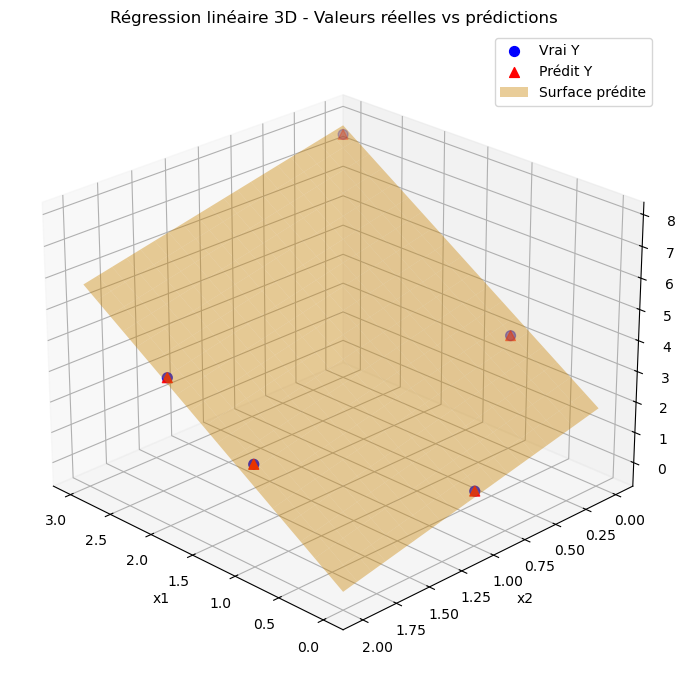

In [13]:

X = np.array([
    [1, 2, 3],
    [0, 1, 2],
    [3, 0, 1],
    [2, 2, 2],
    [1, 0, 0]
])

# Calcul de y avec la fonction y = 2*x1 - x2 + 0.5*x3 + 1
Y = np.array([
    2*1 - 2 + 0.5*3 + 1,   # 2 - 2 + 1.5 + 1 = 2.5
    2*0 - 1 + 0.5*2 + 1,   # 0 - 1 + 1 + 1 = 1.0
    2*3 - 0 + 0.5*1 + 1,   # 6 + 0 + 0.5 + 1 = 7.5
    2*2 - 2 + 0.5*2 + 1,   # 4 - 2 + 1 + 1 = 4.0
    2*1 - 0 + 0.5*0 + 1    # 2 + 0 + 0 + 1 = 3.0
])
n_samples, n_features = X.shape
# === Création et entraînement du modèle ===
model_ptr = lib.create_linear_model_gradient_descent(n_features, 0.1, 1000)

X_flat = X.flatten().astype(np.float64)
Y_float = Y.astype(np.float64)

x_ptr = X_flat.flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double))
y_ptr = Y_float.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

lib.train_linear_model_gradient_descent(model_ptr, x_ptr, y_ptr, n_samples, n_features)



predictions = []
for i in range(n_samples):
    x = X[i].astype(np.float64)
    x_ptr = x.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    pred = lib.predict_linear_model_gradient_descent(model_ptr, x_ptr, n_features)
    predictions.append(pred)
    print(f"Exemple {i} : Prédit = {pred:.3f}, Vrai = {Y[i]}")

predictions = np.array(predictions)

mae = np.mean(np.abs(Y - predictions))
rmse = np.sqrt(np.mean((Y - predictions)**2))
value_range = Y.max() - Y.min()
accuracy_pct = 100 * (1 - rmse / value_range) if value_range > 0 else 100.0

print(f"\nMAE (erreur absolue moyenne) : {mae:.4f}")
print(f"RMSE (erreur quadratique moyenne) : {rmse:.4f}")
print(f"Précision relative : {accuracy_pct:.2f}%")

# === Visualisation 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# === Points réels (Y) en bleu
ax.scatter(X[:, 0], X[:, 1], Y, c='blue', label="Vrai Y", s=50)

# === Points prédits (predictions) en rouge
ax.scatter(X[:, 0], X[:, 1], predictions, c='red', label="Prédit Y", marker='^', s=50)

# === Segments entre vrai et prédit
for i in range(len(Y)):
    x0, x1 = X[i, 0], X[i, 1]
    y_true = Y[i]
    y_pred = predictions[i]
    ax.plot([x0, x0], [x1, x1], [y_true, y_pred], color='gray', linestyle='--', linewidth=1)

# === Surface de prédiction avec x3 constant (ex: moyenne)
x_grid, y_grid = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), 20),
    np.linspace(X[:, 1].min(), X[:, 1].max(), 20)
)

x3_const = X[:, 2].mean()
xyz_grid = np.c_[
    x_grid.ravel(),
    y_grid.ravel(),
    np.full(x_grid.size, x3_const)
]

z_pred = np.array([
    lib.predict_linear_model_gradient_descent(
        model_ptr,
        point.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n_features
    ) for point in xyz_grid
])
z_grid = z_pred.reshape(x_grid.shape)

# === Surface prédite
ax.plot_surface(x_grid, y_grid, z_grid, color='orange', alpha=0.4, label="Surface prédite")

# === Axes et titre
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
ax.set_title("Régression linéaire 3D - Valeurs réelles vs prédictions")

# === Légende et vue
ax.view_init(elev=25, azim=135)  # Orientation 3D
ax.legend()

plt.tight_layout()
plt.show()

### Linear Tricky 3D :
        Linear Model    : OK

Exemple 0 : Prédit = 1.000, Vrai = 1
Exemple 1 : Prédit = 2.000, Vrai = 2
Exemple 2 : Prédit = 3.000, Vrai = 3

MAE (erreur absolue moyenne) : 0.0000
RMSE (erreur quadratique moyenne) : 0.0000
Précision relative : 100.00%


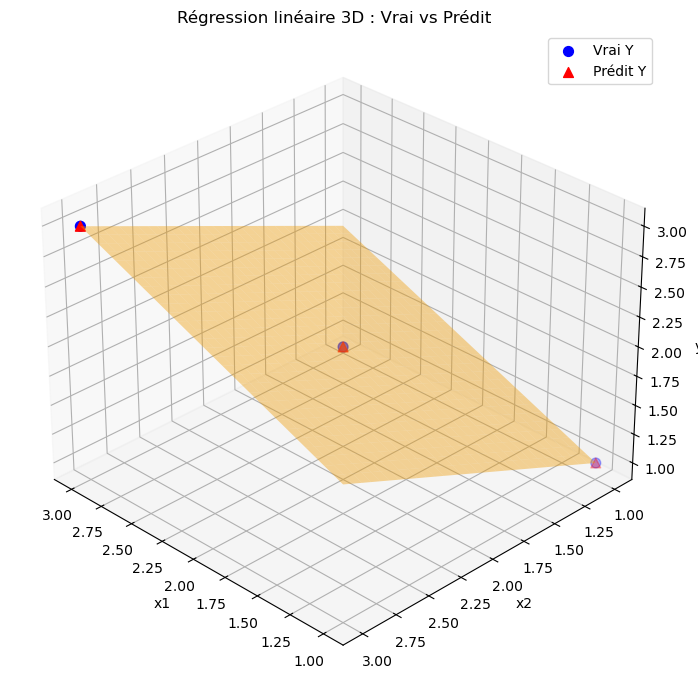

In [21]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 3]
])
Y = np.array([
      1,
      2,
      3
])

n_samples, n_features = X.shape
# === Création et entraînement du modèle ===
model_ptr = lib.create_linear_model_gradient_descent(n_features, 0.1, 1000)

X_flat = X.flatten().astype(np.float64)
Y_float = Y.astype(np.float64)

x_ptr = X_flat.flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double))
y_ptr = Y_float.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

lib.train_linear_model_gradient_descent(model_ptr, x_ptr, y_ptr, n_samples, n_features)



predictions = []
for i in range(n_samples):
    x = X[i].astype(np.float64)
    x_ptr = x.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    pred = lib.predict_linear_model_gradient_descent(model_ptr, x_ptr, n_features)
    predictions.append(pred)
    print(f"Exemple {i} : Prédit = {pred:.3f}, Vrai = {Y[i]}")

predictions = np.array(predictions)

mae = np.mean(np.abs(Y - predictions))
rmse = np.sqrt(np.mean((Y - predictions)**2))
value_range = Y.max() - Y.min()
accuracy_pct = 100 * (1 - rmse / value_range) if value_range > 0 else 100.0

print(f"\nMAE (erreur absolue moyenne) : {mae:.4f}")
print(f"RMSE (erreur quadratique moyenne) : {rmse:.4f}")
print(f"Précision relative : {accuracy_pct:.2f}%")

# === Visualisation 3D pour 2 features
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Points réels (Y) en bleu
ax.scatter(X[:, 0], X[:, 1], Y, c='blue', label="Vrai Y", s=50)

# Points prédits (predictions) en rouge
ax.scatter(X[:, 0], X[:, 1], predictions, c='red', label="Prédit Y", marker='^', s=50)

# Segments entre vrai et prédit
for i in range(len(Y)):
    x0, x1 = X[i, 0], X[i, 1]
    y_true = Y[i]
    y_pred = predictions[i]
    ax.plot([x0, x0], [x1, x1], [y_true, y_pred], color='gray', linestyle='--', linewidth=1)

# Grille pour surface
x_grid, y_grid = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), 30),
    np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
)

xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]  # 2 colonnes seulement

z_pred = np.array([
    lib.predict_linear_model_gradient_descent(
        model_ptr,
        point.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n_features
    ) for point in xy_grid
])
z_grid = z_pred.reshape(x_grid.shape)

# Surface prédite
ax.plot_surface(x_grid, y_grid, z_grid, color='orange', alpha=0.4)

# Axes et titres
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
ax.set_title("Régression linéaire 3D : Vrai vs Prédit")

ax.view_init(elev=30, azim=135)
ax.legend()
plt.tight_layout()
plt.show()

### Non Linear Simple 3D :
        Linear Model       : KO

Exemple 0 : Prédit = 0.333, Vrai = 2
Exemple 1 : Prédit = -0.833, Vrai = 1
Exemple 2 : Prédit = -1.000, Vrai = -2
Exemple 3 : Prédit = 0.500, Vrai = -1

MAE (erreur absolue moyenne) : 1.5000
RMSE (erreur quadratique moyenne) : 1.5321
Précision relative : 61.70%


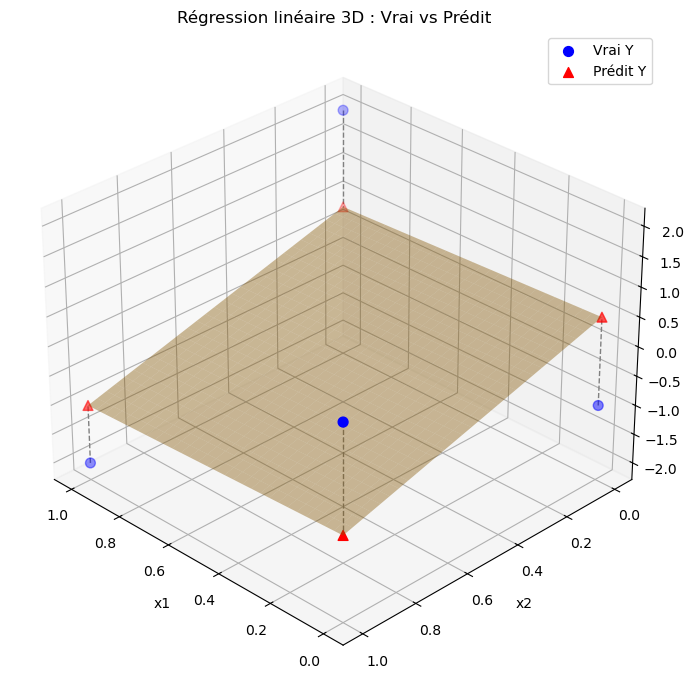

In [20]:
X = np.array([
      [1, 0],
      [0, 1],
      [1, 1],
      [0, 0],
])
Y = np.array([
      2,
      1,
      -2,
      -1
])

n_samples, n_features = X.shape
# === Création et entraînement du modèle ===
model_ptr = lib.create_linear_model_gradient_descent(n_features, 0.1, 1000)

X_flat = X.flatten().astype(np.float64)
Y_float = Y.astype(np.float64)

x_ptr = X_flat.flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double))
y_ptr = Y_float.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

lib.train_linear_model_gradient_descent(model_ptr, x_ptr, y_ptr, n_samples, n_features)



predictions = []
for i in range(n_samples):
    x = X[i].astype(np.float64)
    x_ptr = x.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    pred = lib.predict_linear_model_gradient_descent(model_ptr, x_ptr, n_features)
    predictions.append(pred)
    print(f"Exemple {i} : Prédit = {pred:.3f}, Vrai = {Y[i]}")

predictions = np.array(predictions)

mae = np.mean(np.abs(Y - predictions))
rmse = np.sqrt(np.mean((Y - predictions)**2))
value_range = Y.max() - Y.min()
accuracy_pct = 100 * (1 - rmse / value_range) if value_range > 0 else 100.0

print(f"\nMAE (erreur absolue moyenne) : {mae:.4f}")
print(f"RMSE (erreur quadratique moyenne) : {rmse:.4f}")
print(f"Précision relative : {accuracy_pct:.2f}%")

# === Visualisation 3D pour 2 features
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Points réels (Y) en bleu
ax.scatter(X[:, 0], X[:, 1], Y, c='blue', label="Vrai Y", s=50)

# Points prédits (predictions) en rouge
ax.scatter(X[:, 0], X[:, 1], predictions, c='red', label="Prédit Y", marker='^', s=50)

# Segments entre vrai et prédit
for i in range(len(Y)):
    x0, x1 = X[i, 0], X[i, 1]
    y_true = Y[i]
    y_pred = predictions[i]
    ax.plot([x0, x0], [x1, x1], [y_true, y_pred], color='gray', linestyle='--', linewidth=1)

# Grille pour surface
x_grid, y_grid = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), 30),
    np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
)

xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]  # 2 colonnes seulement

z_pred = np.array([
    lib.predict_linear_model_gradient_descent(
        model_ptr,
        point.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n_features
    ) for point in xy_grid
])
z_grid = z_pred.reshape(x_grid.shape)

# Surface prédite
ax.plot_surface(x_grid, y_grid, z_grid, color='orange', alpha=0.4)

# Axes et titres
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
ax.set_title("Régression linéaire 3D : Vrai vs Prédit")

ax.view_init(elev=30, azim=135)
ax.legend()
plt.tight_layout()
plt.show()